# MNIST

The MNIST dataset was one of the first well-known datasets that machine learning was applied to. This was a set of handwritten digits, like the one you see below. The [()] syntax below indicates that we should load all the data from an H5 dataset into memory.

In [1]:
import h5py as h5
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = h5.File("Files/mnist.h5")
X_train = data['train']['inputs'][()]
X_test = data['test']['inputs'][()]
y_train = data['train']['targets'][()]
y_test = data['test']['targets'][()]

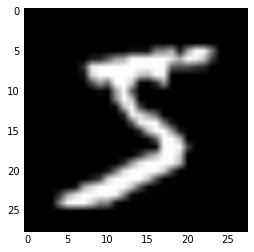

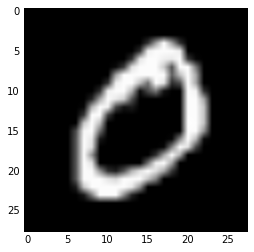

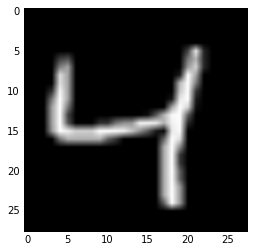

In [3]:
plt.imshow(X_train[0], cmap='gray')
plt.show()
plt.imshow(X_train[1], cmap='gray')
plt.show()
plt.imshow(X_train[2], cmap='gray')
plt.show()

In [4]:
print(y_train[0])
print(y_train[1])
print(y_train[2])

5
0
4


## Data Proprocessing

We will use PyTorch to create a neural net that can identify these numbers based on their images.

Each number is a 28x28 matrix of numbers between 0 and 255. They have associated labels. We need to convert the values to floats, normalized between 0 and 1.

In [5]:
from sklearn import preprocessing
import numpy as np

In [6]:
X_train = X_train.astype(np.float32)/255
X_test = X_test.astype(np.float32)/255
y_train = y_train.astype(np.long)
y_test = y_test.astype(np.long)

PyTorch will automatically convert class indices into one-hot format for us. If we wanted to do it manually, this is how we would do it.

In [7]:
encoding = preprocessing.OneHotEncoder(sparse=False)
y_train_one_hot = encoding.fit_transform(np.array(y_train).reshape(len(y_train), 1)).astype(np.long)

In [8]:
print(y_train_one_hot[0])
print(y_train_one_hot[1])
print(y_train_one_hot[2])

[0 0 0 0 0 1 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0]


## Training

First we create Dataset and DataLoader objects that are able to take the training and test data and return items when called. This is required to run a job in PyTorch. The Dataset can be created from an array of Tensors.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader, sampler
import torch.nn.functional as F

In [10]:
X_train = np.array([i.reshape(1, 28, 28) for i in X_train])
X_test = np.array([i.reshape(1, 28, 28) for i in X_test])

In [11]:
train_set = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_set = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
train_loader = DataLoader(dataset=train_set, sampler=sampler.RandomSampler(train_set), batch_size=100)
test_loader = DataLoader(dataset=test_set, sampler=sampler.RandomSampler(test_set), batch_size=100)

Now we create a net for analyzing an input image, and define an optimizer.

In [29]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28*28, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

model = Net()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [30]:
def train(model, train_loader, optimizer):
    model.train()
    for epoch in range(10):
        for data, target in train_loader:
            optimizer.zero_grad()
            prediction = model(data)
            loss = F.cross_entropy(prediction, target)
            loss.backward()
            optimizer.step()

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [31]:
train(model, train_loader, optimizer)
test(model, test_loader)


Test set: Average loss: -0.9401, Accuracy: 9463/10000 (95%)

